In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from zipfile import ZipFile
from google.colab import files
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/vehicle.zip'


In [12]:
extracted_dir_path = '/content/vehicle_dataset/vehicle'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [13]:
base_dir_path = extracted_dir_path
train_dir_path = os.path.join(base_dir_path, 'train')
test_dir_path = os.path.join(base_dir_path, 'test')

In [17]:
def count_images_updated(directory_path):
    categories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    image_count = {}
    for category in categories:
        category_path = os.path.join(directory_path, category)
        image_count[category] = len(os.listdir(category_path))
    return image_count


In [18]:
# Get the count of images for each category in the training directory using the updated function
image_count_train_updated = count_images_updated(train_dir_path)
image_count_train_updated

{'bike': 48,
 'scooty': 60,
 'car': 60,
 'helicopter': 48,
 'plane': 48,
 'boat': 48,
 'truck': 48,
 'bus': 48,
 'cycle': 60}

Loading image from path: /content/vehicle_dataset/vehicle/train/bike/images (3).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/scooty/images (28).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/car/images (28).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/helicopter/images (3).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/plane/images (3).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/boat/images (3).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/truck/images (3).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/bus/images (3).jpg
Loading image from path: /content/vehicle_dataset/vehicle/train/cycle/images (28).jpg


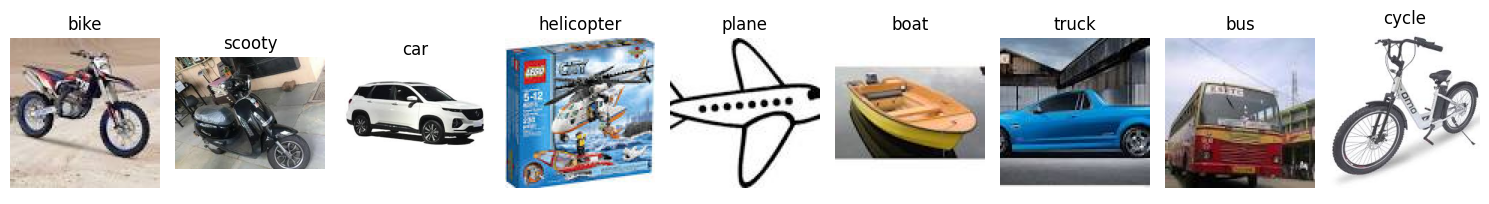

In [20]:
def display_sample_images_debug(directory_path, image_count, sample_size=1):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_count), figsize=(15, 5))

    # Convert axes to list if it's not iterable
    if len(image_count) == 1:
        axes = [axes]

    for ax, category in zip(axes, image_count.keys()):
        category_path = os.path.join(directory_path, category)
        sample_images = os.listdir(category_path)[:sample_size]
        img_path = os.path.join(category_path, sample_images[0])

        # Print image path for debugging
        print(f"Loading image from path: {img_path}")

        with Image.open(img_path) as img:
            ax.imshow(img)
            ax.set_title(category)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the debug function
display_sample_images_debug(train_dir_path, image_count_train_updated)


<ipython-input-22-dbf7b4dce3d3>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(list(image_count_train_updated.keys()), rotation=45)
<ipython-input-22-dbf7b4dce3d3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(list(image_count_test_updated.keys()), rotation=45)


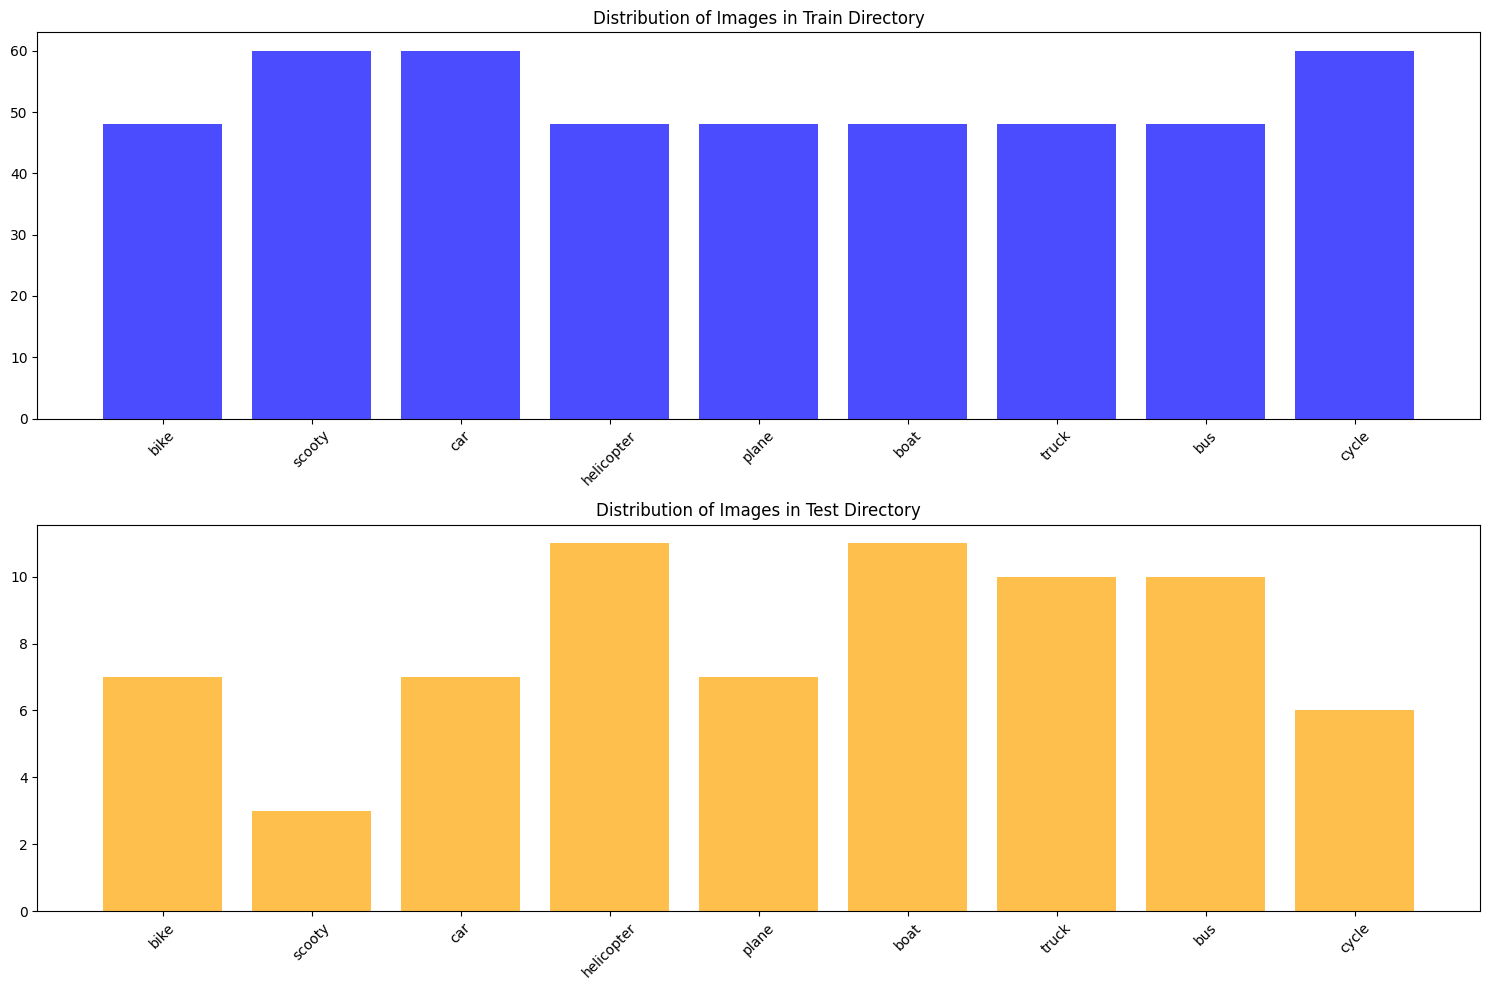

In [22]:
# Count the images in the test directory
image_count_test_updated = count_images_updated(test_dir_path)

# Plot the distribution of images across categories for both train and test directories
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].bar(image_count_train_updated.keys(), image_count_train_updated.values(), color='blue', alpha=0.7)
ax[0].set_title('Distribution of Images in Train Directory')
ax[0].set_xticklabels(list(image_count_train_updated.keys()), rotation=45)
ax[1].bar(image_count_test_updated.keys(), image_count_test_updated.values(), color='orange', alpha=0.7)
ax[1].set_title('Distribution of Images in Test Directory')
ax[1].set_xticklabels(list(image_count_test_updated.keys()), rotation=45)
plt.tight_layout()
plt.show()


In [29]:
def average_image_color_updated(directory_path, image_count):
    avg_colors = {}
    for category in image_count.keys():
        category_path = os.path.join(directory_path, category)
        total_color = np.zeros(3)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Ensure the image is in RGB mode
                img_array = np.array(img)
                avg_color = img_array.reshape(-1, 3).mean(axis=0)
                total_color += avg_color
        avg_colors[category] = (total_color / image_count[category]).astype(int)
    return avg_colors

In [31]:
# Calculate average colors for train and test directories using the updated function
avg_colors_train_updated = average_image_color_updated(train_dir_path, image_count_train_updated)
avg_colors_test_updated = average_image_color_updated(test_dir_path, image_count_test_updated)

avg_colors_train_updated, avg_colors_test_updated

({'bike': array([161, 159, 160]),
  'scooty': array([176, 173, 169]),
  'car': array([140, 135, 137]),
  'helicopter': array([142, 150, 158]),
  'plane': array([142, 150, 159]),
  'boat': array([139, 147, 150]),
  'truck': array([140, 137, 134]),
  'bus': array([132, 128, 124]),
  'cycle': array([191, 189, 186])},
 {'bike': array([176, 175, 175]),
  'scooty': array([187, 186, 187]),
  'car': array([115, 111, 111]),
  'helicopter': array([169, 174, 186]),
  'plane': array([167, 161, 157]),
  'boat': array([139, 145, 153]),
  'truck': array([162, 161, 159]),
  'bus': array([138, 138, 132]),
  'cycle': array([211, 215, 211])})

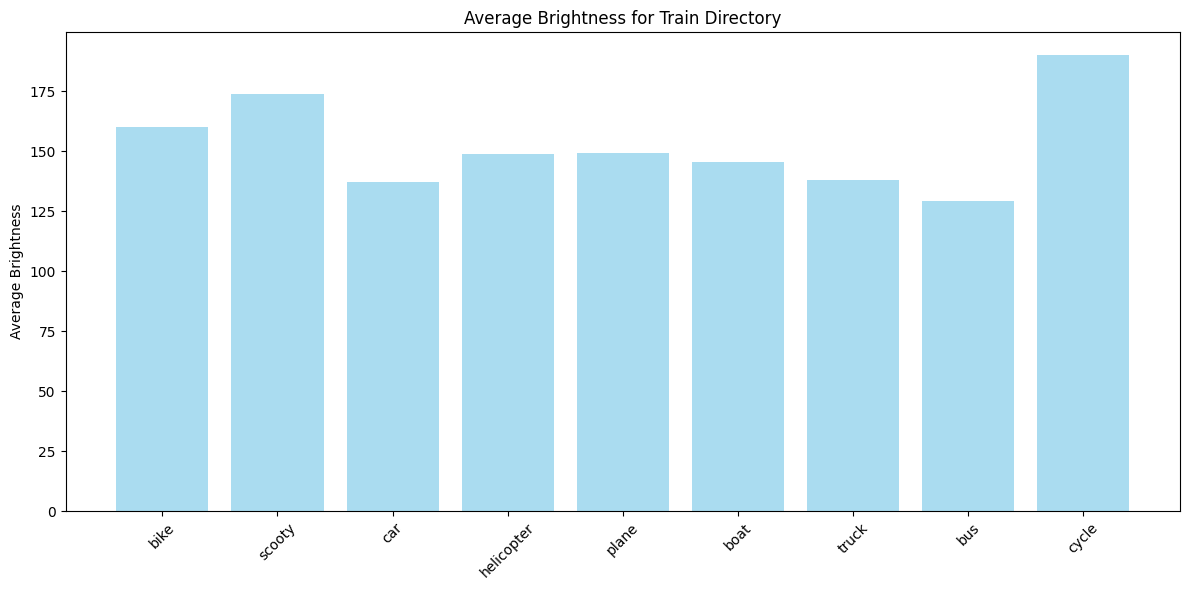

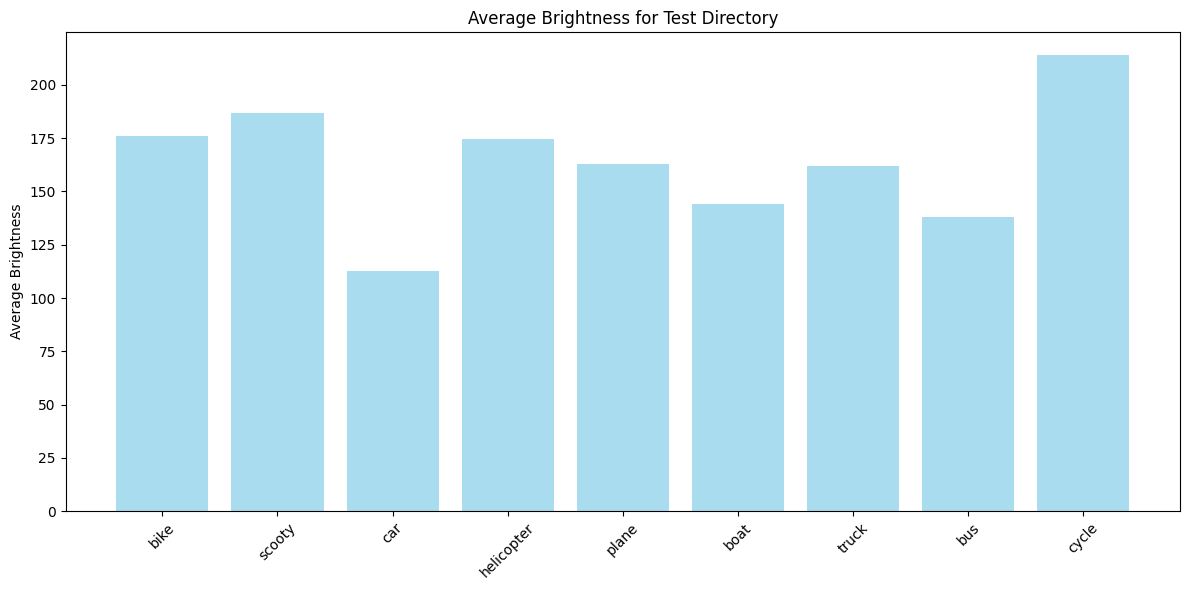

In [34]:
def average_brightness(directory_path, image_count):
    avg_brightness = {}
    for category in image_count.keys():
        category_path = os.path.join(directory_path, category)
        total_brightness = 0
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                img_gray = img.convert('L')  # Convert image to grayscale
                brightness = np.array(img_gray).mean()  # Calculate average brightness
                total_brightness += brightness
        avg_brightness[category] = total_brightness / image_count[category]
    return avg_brightness

# Calculate average brightness for train and test directories
avg_brightness_train = average_brightness(train_dir_path, image_count_train_updated)
avg_brightness_test = average_brightness(test_dir_path, image_count_test_updated)

# Function to display average brightness
def display_average_brightness(avg_brightness, title):
    plt.figure(figsize=(12, 6))
    plt.bar(avg_brightness.keys(), avg_brightness.values(), color='skyblue', alpha=0.7)
    plt.title(title)
    plt.ylabel('Average Brightness')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Display the average brightness for train and test directories
display_average_brightness(avg_brightness_train, "Average Brightness for Train Directory")
display_average_brightness(avg_brightness_test, "Average Brightness for Test Directory")



<ipython-input-35-efdfc17ef88c>:13: RuntimeWarning: overflow encountered in ubyte_scalars
  contrast = (max_val - min_val) / (max_val + min_val)  # Calculate contrast
<ipython-input-35-efdfc17ef88c>:13: RuntimeWarning: divide by zero encountered in ubyte_scalars
  contrast = (max_val - min_val) / (max_val + min_val)  # Calculate contrast


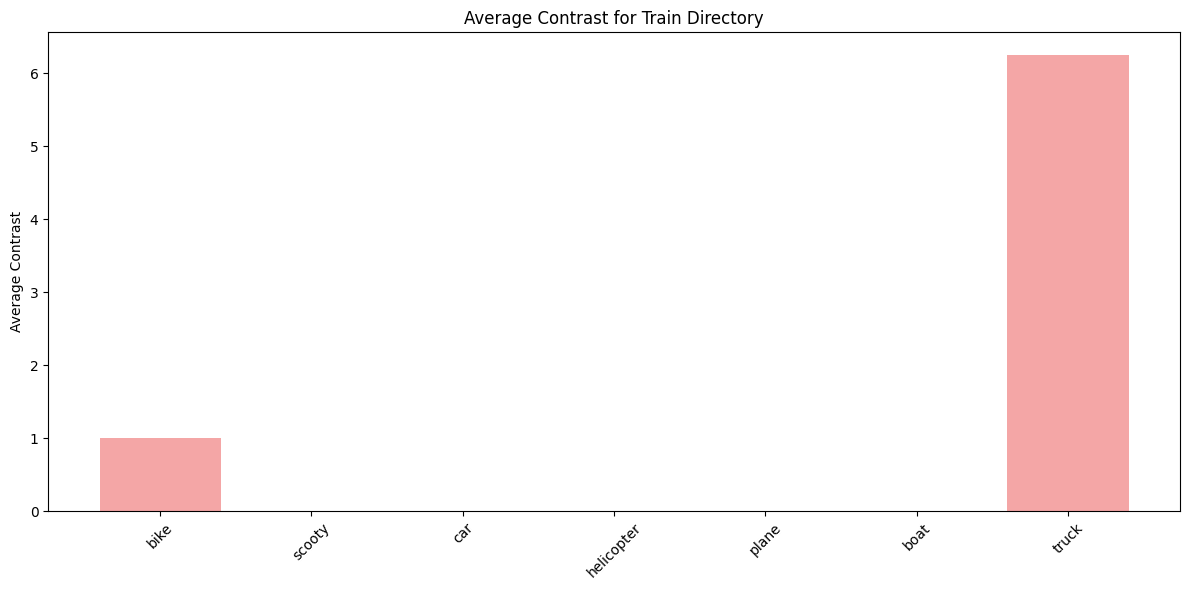

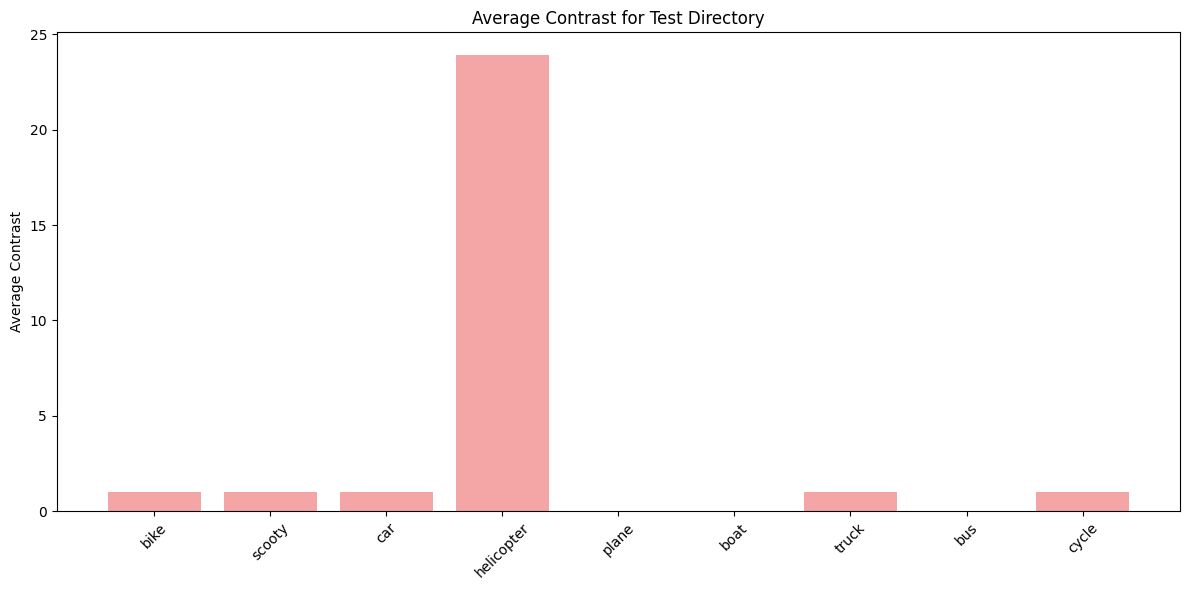

In [35]:
def average_contrast(directory_path, image_count):
    avg_contrast = {}
    for category in image_count.keys():
        category_path = os.path.join(directory_path, category)
        total_contrast = 0
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                img_gray = img.convert('L')  # Convert image to grayscale
                img_array = np.array(img_gray)
                max_val = img_array.max()
                min_val = img_array.min()
                contrast = (max_val - min_val) / (max_val + min_val)  # Calculate contrast
                total_contrast += contrast
        avg_contrast[category] = total_contrast / image_count[category]
    return avg_contrast

# Calculate average contrast for train and test directories
avg_contrast_train = average_contrast(train_dir_path, image_count_train_updated)
avg_contrast_test = average_contrast(test_dir_path, image_count_test_updated)

# Function to display average contrast
def display_average_contrast(avg_contrast, title):
    plt.figure(figsize=(12, 6))
    plt.bar(avg_contrast.keys(), avg_contrast.values(), color='lightcoral', alpha=0.7)
    plt.title(title)
    plt.ylabel('Average Contrast')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Display the average contrast for train and test directories
display_average_contrast(avg_contrast_train, "Average Contrast for Train Directory")
display_average_contrast(avg_contrast_test, "Average Contrast for Test Directory")



In [47]:
def extract_color_histogram(img_path, bins=(8, 8, 8)):
    """Extract a 3D color histogram from the RGB image."""
    # Load the image
    img = Image.open(img_path)

    # Convert the image to RGB mode (if not already in RGB)
    img = img.convert("RGB")

    # Compute the histogram
    histogram = img.histogram(mask=None, extrema=None)

    # Normalize the histogram
    hist = np.asarray(histogram, dtype=np.float32)
    hist /= hist.sum()

    return hist

# Define the number of images we're sampling from each category for clustering
sample_size_per_category = 10

# Extracting color histograms for a subset of images from the 'train' directory
histogram_features = []

for category in image_count_train_updated.keys():
    category_path = os.path.join(train_dir_path, category)
    sample_images = os.listdir(category_path)[:sample_size_per_category]
    for img_name in sample_images:
        img_path = os.path.join(category_path, img_name)
        hist = extract_color_histogram(img_path)
        histogram_features.append(hist)

histogram_features = np.array(histogram_features)

histogram_features.shape


(90, 768)

In [48]:
from sklearn.decomposition import PCA

# Applying PCA to reduce dimensions
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(histogram_features)

reduced_features.shape


(90, 50)

In [50]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = len(image_count_train_updated.keys())

# Applying KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(reduced_features)

cluster_assignments


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 1, 0, 1, 2, 2, 0, 1, 2,
       2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 6, 2, 2, 2, 2, 2, 0, 8, 4, 2, 2, 2, 2, 2, 0,
       0, 2, 3, 2, 2, 2, 2, 2, 7, 2, 2, 2, 5, 2, 1, 2, 1, 1, 7, 1, 1, 1,
       1, 1], dtype=int32)

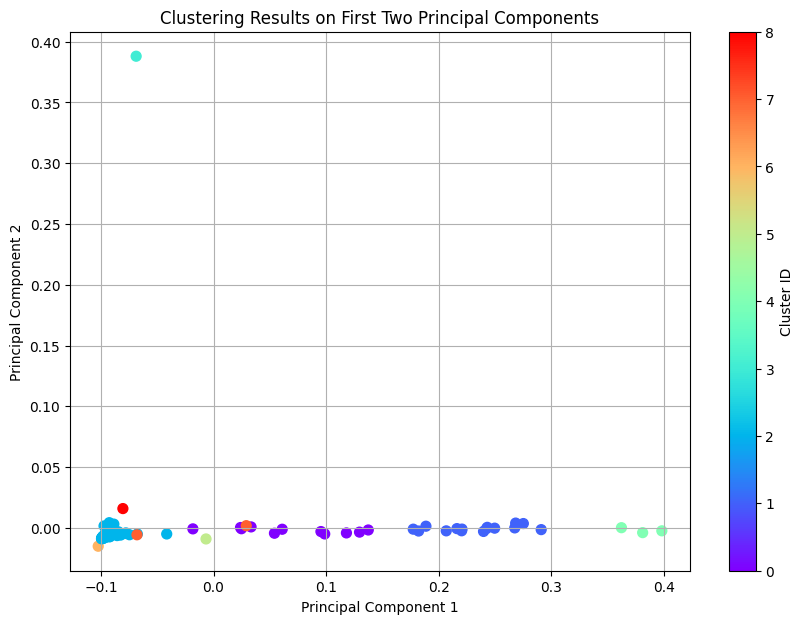

In [51]:
# Scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_assignments, cmap='rainbow', s=50)
plt.title("Clustering Results on First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar().set_label('Cluster ID')
plt.grid(True)
plt.show()


In [55]:
all_labels = []
for category in image_count_train_updated.keys():
    category_path = os.path.join(train_dir_path, category)
    sample_images = os.listdir(category_path)[:sample_size_per_category]
    all_labels.extend([category] * len(sample_images))


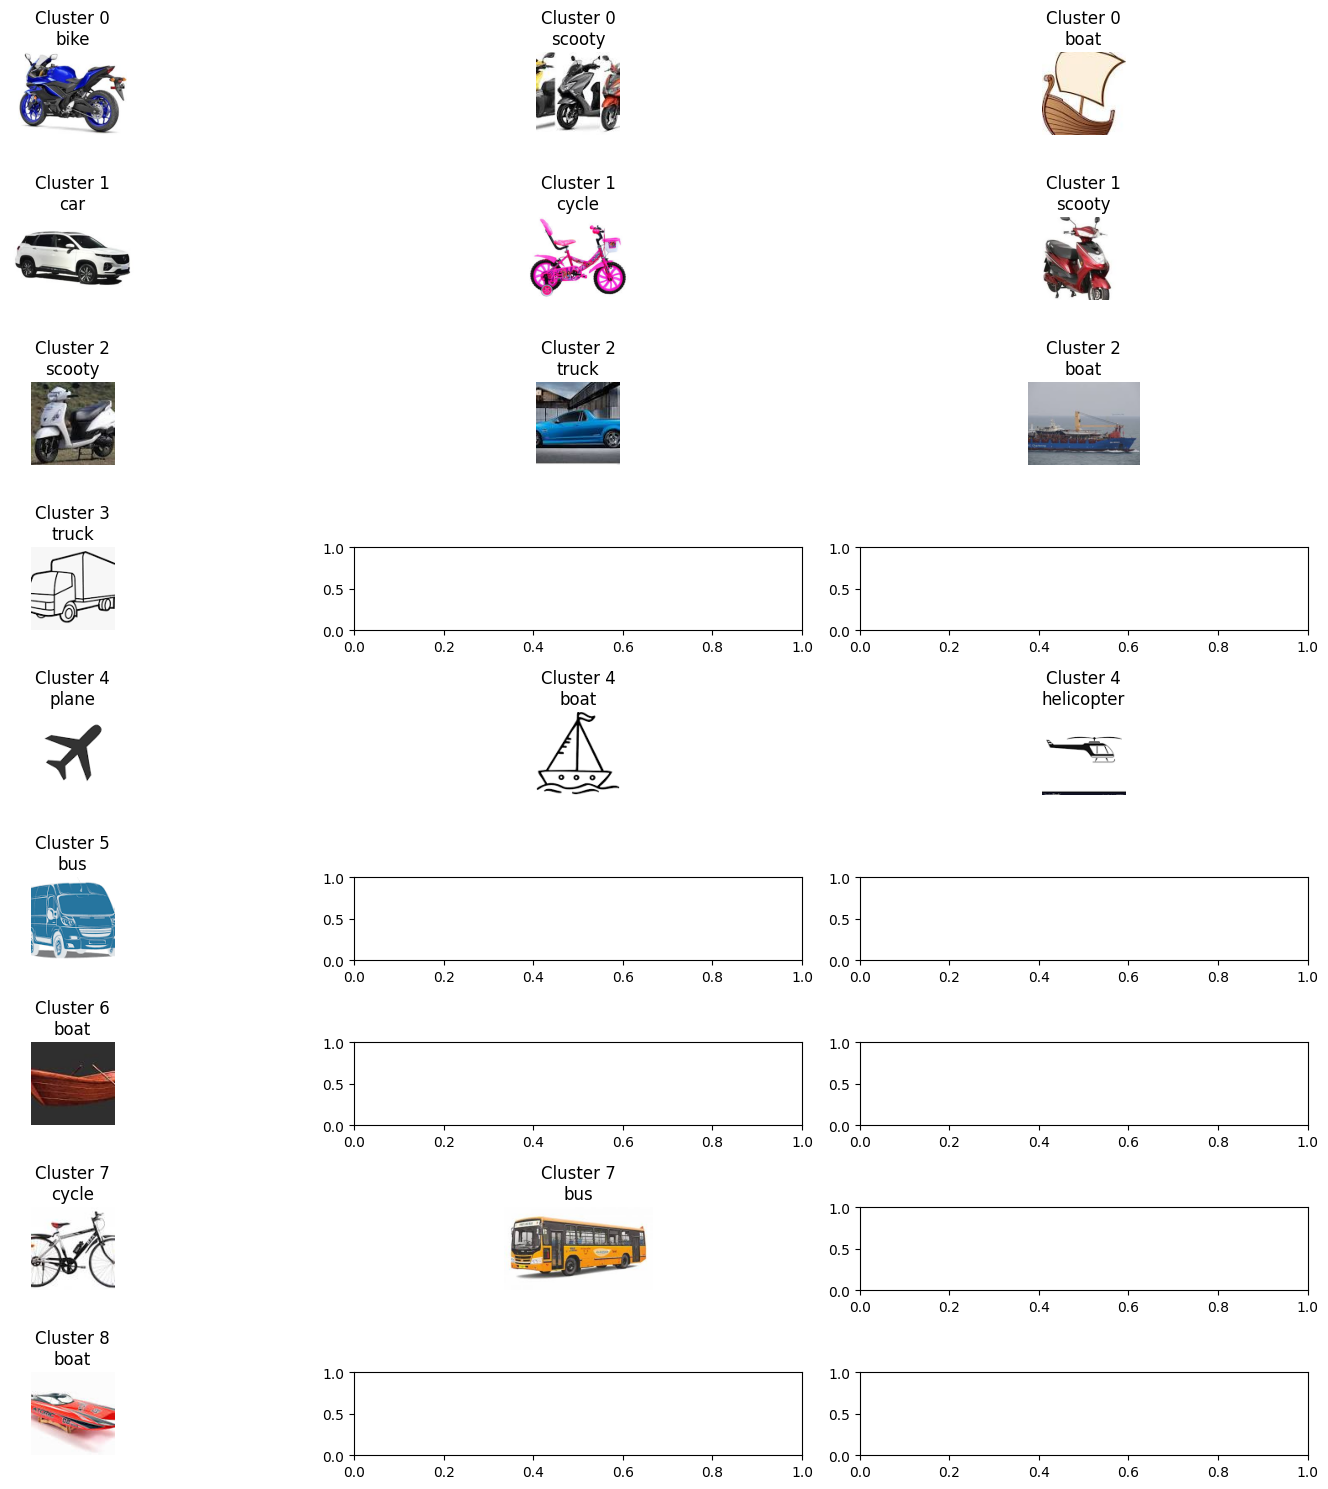

In [56]:
def display_sample_images_from_clusters_corrected(directory_path, cluster_assignments, labels, num_clusters, sample_size=3):
    """Display sample images from each cluster with corrected sampling."""
    fig, axes = plt.subplots(nrows=num_clusters, ncols=sample_size, figsize=(15, 15))

    for cluster_id in range(num_clusters):
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]
        actual_sample_size = min(len(cluster_indices), sample_size)
        sample_indices = np.random.choice(cluster_indices, actual_sample_size, replace=False)
        for ax, idx in zip(axes[cluster_id], sample_indices):
            category = labels[idx]
            category_path = os.path.join(directory_path, category)
            all_images = os.listdir(category_path)
            img_name = all_images[idx % sample_size_per_category]
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"Cluster {cluster_id}\n{category}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Displaying sample images from each cluster with corrected sampling
display_sample_images_from_clusters_corrected(train_dir_path, cluster_assignments, all_labels, n_clusters)



In [57]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
sil_score = silhouette_score(reduced_features, cluster_assignments)

sil_score


0.55441386

In [58]:
from sklearn.ensemble import IsolationForest

# Using Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Assuming ~5% of the data might be anomalous
anomaly_scores = iso_forest.fit_predict(histogram_features)

# Identifying the indices of the anomalies
anomaly_indices = np.where(anomaly_scores == -1)[0]

anomaly_indices, len(anomaly_indices)


(array([34, 36, 37, 47, 78]), 5)

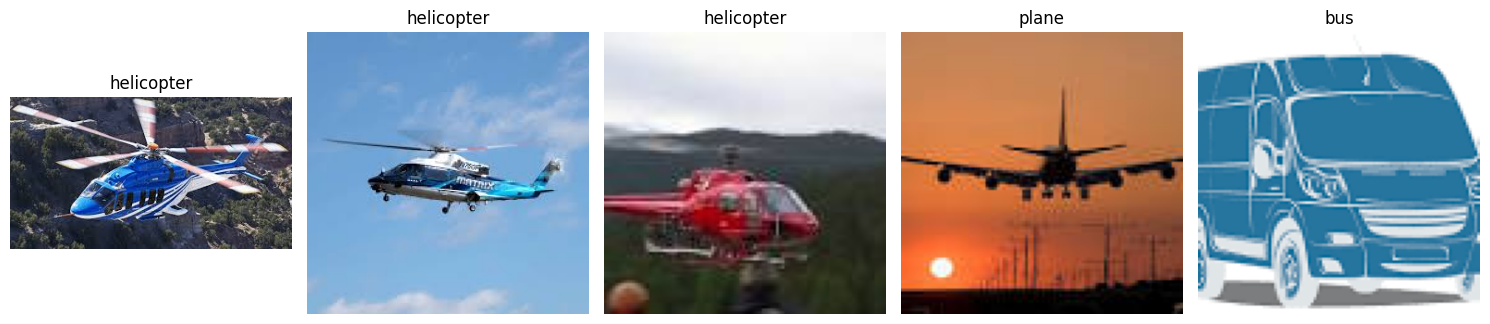

In [59]:
def display_anomalous_images(directory_path, anomaly_indices, labels):
    """Display the detected anomalous images."""
    fig, axes = plt.subplots(1, len(anomaly_indices), figsize=(15, 5))

    for ax, idx in zip(axes, anomaly_indices):
        category = labels[idx]
        category_path = os.path.join(directory_path, category)
        all_images = os.listdir(category_path)
        img_name = all_images[idx % sample_size_per_category]
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Displaying the detected anomalous images
display_anomalous_images(train_dir_path, anomaly_indices, all_labels)
